In [1]:
# importing the necessary libraries 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model 
import numpy as np 
import matplotlib.pyplot as plt 
import csv
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from time import time
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from seaborn import heatmap
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, precision_score,roc_auc_score)
import xlsxwriter

In [ ]:
# I am thankful to the people who contributed to the ome parts of the code. I have borrowed code from the below sources:
# 1. https://blog.keras.io/building-autoencoders-in-keras.html
# 2. https://keras.io/examples/generative/dcgan_overriding_train_step/
# 3. https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd


In [2]:
# checking the required versions of the packages in python

In [3]:
pd.__version__

'0.25.1'

In [4]:
tf.__version__

'2.3.1'

In [5]:
keras.__version__

'2.4.0'

In [6]:
np.__version__

'1.16.5'

In [7]:
xlsxwriter.__version__

'1.2.1'

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7189663318729348050
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16831780910434596671
physical_device_desc: "device: XLA_CPU device"
]


In [9]:
from keras import backend as K


In [10]:
# check GPUS if available

#import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus
tfback._get_available_gpus()

ModuleNotFoundError: No module named 'keras.backend.tensorflow_backend'; 'keras.backend' is not a package

In [11]:
creditcard = pd.read_csv("creditcard.csv")

In [12]:
creditcard.shape

(284807, 31)

In [13]:
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [14]:
desc = creditcard.describe()
desc

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [15]:
#Standardise the 'Amount' variable

creditcard['Amount'] = StandardScaler().fit_transform(creditcard['Amount'].values.reshape(-1, 1))


In [16]:
# checking if the standaardisation of 'Amount' variable is done correctly
desc = creditcard.describe()
desc

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,3.202236e-16,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,1.000002e+00,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-3.532294e-01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-3.308401e-01,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-2.652715e-01,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-4.471707e-02,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.023622e+02,1.000000


In [17]:
# Splitting train and test samples from the main dataset

train, test = train_test_split(creditcard, test_size=0.3, random_state=100)
X_train_non_fraud = train[train.Class == 0]
Y_train_non_fraud = X_train_non_fraud['Class']
X_train_non_fraud = X_train_non_fraud.drop(['Class','Time'], axis=1)

print(X_train_non_fraud.shape)
print(Y_train_non_fraud.shape)


X_train_fraud = train[train.Class == 1]
Y_train_fraud = X_train_fraud['Class']
X_train_fraud = X_train_fraud.drop(['Class','Time'], axis=1)
print(X_train_fraud.shape)
print(Y_train_fraud.shape)


X_test = test.drop(['Class','Time'], axis=1)
Y_test = test['Class']


print(X_test.shape)
print(Y_test.shape)

(199014, 29)
(199014,)
(350, 29)
(350,)
(85443, 29)
(85443,)


In [18]:
# Drop Class and Time variables from the train dataset 

X_train = train.drop(['Class','Time'], axis=1)
Y_train = train['Class']

print(X_train.shape)
print(Y_train.shape)

train_features =  X_train.loc[:,~X_train.columns.isin(['Class','Time'])].values
train_targets =  train.loc[:,train.columns.isin(['Class'])].values

print(len(train_features))
print(len(train_targets))

(199364, 29)
(199364,)
199364
199364


In [19]:
## converting into numpy arrays which is a requirement for neural networks

fraud_features =  X_train_fraud.values
fraud_targets = Y_train_fraud.values
nonfraud_features = X_train_non_fraud.values
nonfraud_targets =  Y_train_non_fraud.values

test_features =  X_test.loc[:,~X_test.columns.isin(['Class','Time'])].values
test_targets =  test.loc[:,test.columns.isin(['Class'])].values


print("Number of Generator training samples:", len(nonfraud_features))
print("Number of validation samples:", len(fraud_features))
print("Number of test samples:", len(test_features))

Number of Generator training samples: 199014
Number of validation samples: 350
Number of test samples: 85443


In [20]:
# checking the shapes of the fraud and non fraud dataset
print(fraud_features.shape)
print(nonfraud_features.shape)
print(fraud_targets.shape)
print(nonfraud_targets.shape)



(350, 29)
(199014, 29)
(350,)
(199014,)


In [21]:
# Building a function to view the distribution of the generated output

# sample_features = df
def tsne_visualisation(tsne_raw_data):
    #scr = StandardScaler()
    #sample_features = scr.fit_transform(sample_features)
    #print(sample_features.shape,sample_class.shape)
    
    model_tsne = TSNE(n_components=2,random_state=10,perplexity=20)
    # print(sample_features,sample_class)

    t0 = time()
    embedded_data = model_tsne.fit_transform(tsne_raw_data)
    print("TSNE done in %0.3fs." % (time() - t0)) 

    newdf = pd.DataFrame(data=embedded_data,columns=["Dim1","Dim2"])

    sns.FacetGrid(newdf,height=6).map(plt.scatter,"Dim1","Dim2").add_legend()
    plt.title("Perplexity used is 20")
    plt.show()
    plt.close()

In [22]:
## Final initialisation used is Kaiming as per results, so initialising only Kaiming here:

## Kaiming Initializer for dense layer

kaiming_init = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')

## Glorot Initializer for dense layer

#glorot_init = tf.keras.initializers.GlorotUniform()


In [23]:
### Traning Loop for GAN results

# Final best hyperparameter configuration
num_epochs=[200]
batch_size=[512]
initialisation = [kaiming_init ]
learning_rate = [0.00001]

## Other hyperparameters tried :
#P.S this code may not have all the 100 combinations tried for hyperparamnters

#num_epochs=[600,800]
#batch_size=[1024]
#initialisation = [kaiming_init ]
#learning_rate = [0.1,0.01,0.001,0.0001]


# Iter best - 3 hours
#num_epochs=[200,400]
#batch_size=[1024]
#initialisation = [kaiming_init ]
#learning_rate = [0.1,0.01,0.001,0.0001]


# Iter 1 - 3 hours
#num_epochs=[200]
#batch_size=[64,128,256]
#initialisation = [kaiming_init ]
#learning_rate = [0.1,0.01, 0.001,0.0001]

# Iter 1,2 - 3 hours
# AUPRC left to run and 512 bs left to run
#num_epochs=[200,400]
#batch_size=[64,128,256,512]
#initialisation = [kaiming_init ]
#learning_rate = [0.1,0.01, 0.001,0.0001]

# Iter 3 - 3 hours

#num_epochs=[600]
#batch_size=[64,128,256,512]
#initialisation = [kaiming_init ]
#learning_rate = [0.1,0.01, 0.001,0.0001]

# Iter 4 - 3 hours

#num_epochs=[800]
#batch_size=[64,128,256,512]
#initialisation = [kaiming_init ]
#learning_rate = [0.1,0.01, 0.001,0.0001]

# Iter 5A - 3 hours

#num_epochs=[1000]
#batch_size=[64,128,256,512]
#initialisation = [kaiming_init ]
#learning_rate = [0.1,0.01]


# Iter 5B - 3 hours

#num_epochs=[1000]
#batch_size=[64,128,256,512]
#initialisation = [kaiming_init ]
#learning_rate = [ 0.001,0.0001]


# Iter 6 - 6 hours

#num_epochs=[1200]
#batch_size=[64,128,256]
#initialisation = [kaiming_init ]
#learning_rate = [0.1,0.01, 0.001,0.0001]

# Iter 7 - 3 hours

#num_epochs=[1400]
#batch_size=[64,128,256]
#initialisation = [kaiming_init ]
#learning_rate = [0.1,0.01, 0.001,0.0001]


# Trails for depth check and normalise check and tanh check
#num_epochs=[500]
#batch_size=[32]
#initialisation = [kaiming_init ]
#learning_rate = [0.01]



a = 0

w,h = 16,205
iter_data = [[0 for x in range(w)] for y in range(h)]

for bs in batch_size:
    
    for lr in learning_rate:
        
        for init in initialisation:
        
            for e in num_epochs:
                
                for i in range(0,35):
                    
                    #print('iteration',i)

                    # Create the discriminator
                    discriminator = keras.Sequential(
                        [
                            keras.Input(shape=(29,)),          
                            keras.layers.Dense(256, activation="relu", kernel_initializer=init),
                            keras.layers.Dropout(0.3),
                            keras.layers.Dense(256, activation="relu", kernel_initializer=init),
                            keras.layers.Dropout(0.3),
                            keras.layers.Dense(256, activation="relu", kernel_initializer=init),
                            keras.layers.Dropout(0.3),
                            keras.layers.Dense(256, activation="relu", kernel_initializer=init),
                            keras.layers.Dropout(0.3),
                            keras.layers.Dense(1, activation = "sigmoid"),
                        ],
                        name="discriminator",
                    )


                    # Create the generator

                    generator = keras.Sequential(
                        [   
                            keras.Input(shape=(29,)),
                            keras.layers.Dense(256, kernel_initializer=init),
                            keras.layers.LeakyReLU(alpha=0.2),
                            keras.layers.Dense(256, kernel_initializer=init),
                            keras.layers.LeakyReLU(alpha=0.2),
                            keras.layers.Dense(256, kernel_initializer=init),
                            keras.layers.LeakyReLU(alpha=0.2),
                            keras.layers.Dense(256, kernel_initializer=init),
                            keras.layers.LeakyReLU(alpha=0.2),
                            keras.layers.Dense(29, activation="linear"),
                        ],
                        name="generator",
                    )


                    #Sampling noise and generating a batch of new non fraud data points to test 
                    #Use the (as yet untrained) generator to create an output
                    noise = tf.random.normal([2,29], 0, 1, tf.float32,seed=1)
                    generated_nonfraud = generator(noise) 



                    # Building and compiling the discriminator 

                    opt= keras.optimizers.Adam(lr,0.5)
                    discriminator.compile(loss='binary_crossentropy', 
                                          optimizer=opt, 
                                        metrics=['accuracy']) 
                      
                    #Making the Discriminator untrainable 
                    #so that the generator can learn from fixed gradient 
                    discriminator.trainable = False
                      
                    # Building the generator 

                    opt_g= keras.optimizers.Adam(lr,0.5)
                    generator.compile(loss='binary_crossentropy', 
                                          optimizer=opt_g, 
                                        metrics=['accuracy']) 
                    #Defining the input for the generator 
                    #and generating the data 
                    z = keras.Input(shape=(29,)) 
                    generated_nonfraud = generator(z,  training=False) 
                      
                    #Use the (as yet untrained) discriminator to classify the generated data as real or fake. 
                    #The model will be trained to output positive values for real data, and negative values for fake data.

                    valid = discriminator(generated_nonfraud , training=False) 
                      
                    #Defining the combined model of the Generator and the Discriminator 
                    combined_network = keras.Model(z, valid) 
                    combined_network.compile(loss='binary_crossentropy', 
                                             optimizer=keras.optimizers.Adam(lr,0.5)) 



                   # display_interval= 300
                    losses=[] 


                              
                    #Defining the Adversarial ground truths 
                    valid = np.ones((bs, 1)) 
                      
                    #Adding some noise  
                    #valid += 0.05 * np.random.random(valid.shape) 
                    fake = np.zeros((bs, 1)) 
                    #fake += 0.05 * np.random.random(fake.shape) 
                      
                    for epoch in range(e): 
                                  
                                #Training the Discriminator 
                                  
                                #Sampling a random of non fraud data points 
                                index = np.random.randint(0, nonfraud_features.shape[0], bs) 
                                nonfraud_sample = nonfraud_features[index] 
                      
                                #Sampling noise and generating a batch of new non fraud data points 
                                noise = np.random.normal(0, 1, (bs, 29)) 
                                generated_nonfraud = generator.predict(noise) 
                                  
                      
                                #Training the discriminator to detect more accurately 
                                #whether a generated datapoint is real or fake 
                                discm_loss_real = discriminator.train_on_batch(nonfraud_sample, valid) 
                                discm_loss_fake = discriminator.train_on_batch(generated_nonfraud, fake) 
                                discm_loss = np.add(discm_loss_real, discm_loss_fake) # 0.5 * np.add(discm_loss_real, discm_loss_fake) 
                                
                                #print('epoch', epoch )
                                #print('discm_loss_real',discm_loss_real)
                                #print('discm_loss_fake',discm_loss_fake)
                                #print('discm_loss',discm_loss)
                                
                                #Training the Generator 
                      
                                #Training the generator to generate data 
                                #which pass the authenticity test 
                                genr_loss = combined_network.train_on_batch(noise, valid) 
                                #print('genr_loss',genr_loss)
                                
                                #Tracking the progress                 
                             #   if epoch % display_interval == 0: 
                             #       tsne_visualisation(nonfraud_sample) 
                             #       tsne_visualisation(noise) 
                             #       tsne_visualisation(generated_nonfraud) 


                    ## checking the output of discriminator on real and fake non fraud data

                    real_nonfraud_data_disc_op = discriminator.predict(nonfraud_features) 


                    ## checking the outputs on real fraud data : 

                    real_fraud_data_disc_op = discriminator.predict(fraud_features) 

                    ## checking the outputs on test data : 

                    test_data_disc_op = discriminator.predict(test_features) 

                    ## checking the outputs on train data : 

                    train_data_disc_op = discriminator.predict(train_features) 
                 

                   ## plot the non fraud and fraud data pd distribution
                   # sns.kdeplot(real_nonfraud_data_disc_op.flatten() , label="prob_real_nonfraud_data_disc_op")
                   # sns.kdeplot(real_fraud_data_disc_op.flatten() , label="prob_real_fraud_data_disc_op")
                    
                   # plt.legend();

                  ## checking the AUC on test data : 
                    
                    test_fraud_auc = metrics.roc_auc_score(Y_test,test_data_disc_op)
                    iter_data[i][a] = test_fraud_auc 
                    
                  ## checking the AUC on train data : 
                    m = i+55
                    train_fraud_auc = metrics.roc_auc_score(Y_train,train_data_disc_op)
                    iter_data[m][a] = train_fraud_auc 
                    
                    ## checking auprc on test data and train data
                    t = i+100
                    test_precision, test_recall, _ = precision_recall_curve(Y_test,test_data_disc_op)
                    test_auprc_score = auc(test_recall, test_precision)
                    iter_data[t][a] = test_auprc_score 
                    
                    
                    q = i+150
                    train_precision, train_recall, _ = precision_recall_curve(Y_train,train_data_disc_op)
                    train_auprc_score = auc(train_recall, train_precision)
                    iter_data[q][a] = train_auprc_score


                    iter_data[200][a] = e 
                    iter_data[201][a] = bs
                    iter_data[202][a] = init
                    iter_data[203][a] = lr

                
                a = a + 1
                print('combination',a)    
                    
                  
                  #  test_fraud_precision = metrics.precision_score(Y_test,test_data_disc_op)
                  #  iter_data[i][1] = test_fraud_precision 
                    
                  #  test_fraud_recall = metrics.recall_score(Y_test,test_data_disc_op)
                  #  iter_data[i][2] = test_fraud_recall 
                    
                  #  test_fraud_f1_score = metrics.f1_score(Y_test,test_data_disc_op)
                  #  iter_data[i][3] = test_fraud_f1_score 
                    
                  #  test_fraud_balanced_accuracy_score = metrics.balanced_accuracy_score(Y_test,test_data_disc_op)
                  #  iter_data[i][4] = test_fraud_balanced_accuracy_score   
    
    
iter_data = pd.DataFrame(iter_data)
#iter_data.to_csv('iter_data1.csv')



combination 1


In [24]:
iter_data = pd.DataFrame(iter_data)
iter_data.to_csv('iter_data_4layer_best_combination_code_check.csv')

In [25]:
# converting predictions into a list
import itertools

train_op_non_fraud = []
train_op_non_fraud = list(itertools.chain(*real_nonfraud_data_disc_op))

train_op_fraud = []
train_op_fraud = list(itertools.chain(*real_fraud_data_disc_op))

test_op = []
test_op = list(itertools.chain(*test_data_disc_op))


In [26]:
# adding the predicted output value to the respective datasets
train_op_non_fraud = pd.DataFrame(train_op_non_fraud, columns =['pred_val_disc'])
train_op_fraud = pd.DataFrame(train_op_fraud, columns =['pred_val_disc'])
test_op = pd.DataFrame(test_op, columns =['pred_val_disc'])

In [27]:
# checking the shape of the dataframes
print(train_op_non_fraud.shape)
print(train_op_fraud.shape)
print(test_op.shape)

(199014, 1)
(350, 1)
(85443, 1)


In [28]:
test_op['Class'] = test['Class'].values

In [29]:
# defining 20 ntiles or deciles in the data bassed on the predicted output value 
def n_tile(df1,df2,df3,bins):
    quantiles = list(df1.quantile(list(np.array(range(0,105,int(100/bins)))/100)))
    
    labels = list(range(1,bins+1,1))
    distribution_1 = np.array(pd.cut(x=df1, bins=quantiles, labels=labels).value_counts(sort=False))/df1.shape[0]
    distribution_2 = np.array(pd.cut(x=df2, bins=quantiles, labels=labels).value_counts(sort=False))/df2.shape[0]
    distribution_3 = np.array(pd.cut(x=df3, bins=quantiles, labels=labels).value_counts(sort=False))/df3.shape[0]

    
    distribution = pd.DataFrame()
    distribution['bands'] = labels
    distribution['cuts'] = quantiles[1:]
    distribution['train_non_fraud'] = distribution_1
    distribution['train_fraud'] = distribution_2
    distribution['test'] = distribution_3
    return distribution

In [30]:
# calling the ntile function to get the 20 ntile and decile cutoffs 
a = n_tile(train_op_non_fraud['pred_val_disc'],train_op_fraud['pred_val_disc'],test_op['pred_val_disc'],20)
b = n_tile(train_op_non_fraud['pred_val_disc'],train_op_fraud['pred_val_disc'],test_op['pred_val_disc'],10)

writer = pd.ExcelWriter('Bands.xlsx', engine='xlsxwriter')
a.to_excel(writer, sheet_name='N_Tile',index=False)
b.to_excel(writer, sheet_name='Decile',index=False)
writer.save()
writer.close()

In [31]:
########### Making the 20 band based on cutoffs taken from prev step on the predicted values ###########
## BANDS ##
def band(x):
    if(x<a['cuts'][0]):
        return 1
    elif(x>=a['cuts'][0] and x<a['cuts'][1]):
        return 2
    elif(x>=a['cuts'][1] and x<a['cuts'][2]):
        return 3
    elif(x>=a['cuts'][2] and x<a['cuts'][3]):
        return 4
    elif(x>=a['cuts'][3] and x<a['cuts'][4]):
        return 5
    elif(x>=a['cuts'][4] and x<a['cuts'][5]):
        return 6
    elif(x>=a['cuts'][5] and x<a['cuts'][6]):
        return 7
    elif(x>=a['cuts'][6] and x<a['cuts'][7]):
        return 8
    elif(x>=a['cuts'][7] and x<a['cuts'][8]):
        return 9
    elif(x>=a['cuts'][8] and x<a['cuts'][9]):
        return 10
    elif(x>=a['cuts'][9] and x<a['cuts'][10]):
        return 11
    elif(x>=a['cuts'][10] and x<a['cuts'][11]):
        return 12
    elif(x>=a['cuts'][11] and x<a['cuts'][12]):
        return 13
    elif(x>=a['cuts'][12] and x<a['cuts'][13]):
        return 14
    elif(x>=a['cuts'][13] and x<a['cuts'][14]):
        return 15
    elif(x>=a['cuts'][14] and x<a['cuts'][15]):
        return 16
    elif(x>=a['cuts'][15] and x<a['cuts'][16]):
        return 17
    elif(x>=a['cuts'][16] and x<a['cuts'][17]):
        return 18
    elif(x>=a['cuts'][17] and x<a['cuts'][18]):
        return 19
    elif(x>=a['cuts'][18] and x<a['cuts'][19]):
        return 20
    else:
        return np.nan
    
train_op_non_fraud['Bins'] = train_op_non_fraud.apply(lambda x:band(x['pred_val_disc']),axis=1)
train_op_fraud['Bins'] = train_op_fraud.apply(lambda x:band(x['pred_val_disc']),axis=1)
test_op['Bins'] = test_op.apply(lambda x:band(x['pred_val_disc']),axis=1)


In [33]:
# writing the dataset to check
train_op_fraud.to_csv('train_fraud_op_kaiming.csv')
train_op_non_fraud.to_csv('train_nonfraud_op_kaiming.csv')


In [ ]:
test_op.to_csv('test_op_kaiming.csv')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


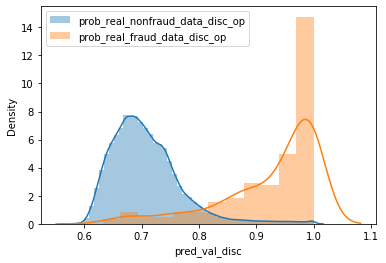

In [40]:
sns.distplot(train_op_non_fraud.pred_val_disc, label="prob_real_nonfraud_data_disc_op")
sns.distplot(train_op_fraud.pred_val_disc, label="prob_real_fraud_data_disc_op")

plt.legend();

In [35]:
#########################################################################################################################
#########################################################################################################################
#########################################################################################################################
#########################################################################################################################
                                   
                                    # Variational Autoencoder for baseline performance 
        
#########################################################################################################################
#########################################################################################################################
#########################################################################################################################
#########################################################################################################################

In [42]:
X_train, X_test = train_test_split(creditcard, test_size=0.3, random_state=100)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class','Time'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class','Time'], axis=1)
X_train = X_train.values
X_test = X_test.values
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(199014, 29)
(85443, 29)
(85443,)


In [43]:
# Create a sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [44]:
# Build the encoder
latent_dim = 3
encoding_dim = 14

encoder_inputs = keras.Input(shape=(29,))
x = keras.layers.Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(encoder_inputs)
x = keras.layers.Dense(int(encoding_dim / 2), activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_106 (InputLayer)          [(None, 29)]         0                                            
__________________________________________________________________________________________________
dense_350 (Dense)               (None, 14)           420         input_106[0][0]                  
__________________________________________________________________________________________________
dense_351 (Dense)               (None, 7)            105         dense_350[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            24          dense_351[0][0]                  
____________________________________________________________________________________________

In [45]:
# Build the decoder
input_dim = 29
latent_dim = 3

latent_inputs = keras.Input(shape=(latent_dim,))
x = keras.layers.Dense(int(encoding_dim / 2), activation='tanh')(latent_inputs)
x = keras.layers.Dense(int(encoding_dim), activation='tanh')(x)
decoder_outputs = keras.layers.Dense(input_dim, activation='relu')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       [(None, 3)]               0         
_________________________________________________________________
dense_352 (Dense)            (None, 7)                 28        
_________________________________________________________________
dense_353 (Dense)            (None, 14)                112       
_________________________________________________________________
dense_354 (Dense)            (None, 29)                435       
Total params: 575
Trainable params: 575
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Instantiate VAE model
decoder_outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, decoder_outputs, name='vae_mlp')

In [47]:
# Compile the VAE model
vae.compile(loss='binary_crossentropy', optimizer='adam')

In [48]:
# Train the VAE model
vae.fit(X_train, X_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, X_test))

Epoch 1/100
6220/6220 [==============================] - 8s 1ms/step - loss: -0.4530 - val_loss: -0.9026
Epoch 2/100
6220/6220 [==============================] - 7s 1ms/step - loss: -1.2292 - val_loss: -1.5334
Epoch 3/100
6220/6220 [==============================] - 7s 1ms/step - loss: -1.6311 - val_loss: -1.8198
Epoch 4/100
6220/6220 [==============================] - 7s 1ms/step - loss: -1.8568 - val_loss: -1.9803
Epoch 5/100
6220/6220 [==============================] - 7s 1ms/step - loss: -1.9885 - val_loss: -2.0449
Epoch 6/100
6220/6220 [==============================] - 7s 1ms/step - loss: -2.0184 - val_loss: -2.0768
Epoch 7/100
6220/6220 [==============================] - 7s 1ms/step - loss: -2.0523 - val_loss: -2.0690
Epoch 8/100
6220/6220 [==============================] - 7s 1ms/step - loss: -2.0715 - val_loss: -2.1173
Epoch 9/100
6220/6220 [==============================] - 7s 1ms/step - loss: -2.1219 - val_loss: -2.1582
Epoch 10/100
6220/6220 [==============================]

In [49]:
predictions = vae.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()


,reconstruction_error,true_class
count,85443.000000,85443.000000
mean,1.123622,0.001662
std,7.438109,0.040733
min,0.100052,0.000000
25%,0.465880,0.000000
50%,0.728575,0.000000
75%,1.060078,0.000000
max,1842.558957,1.000000


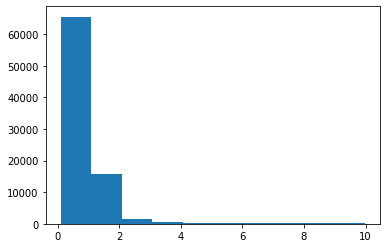

In [50]:
# Reconstruction error on non fraud data points
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

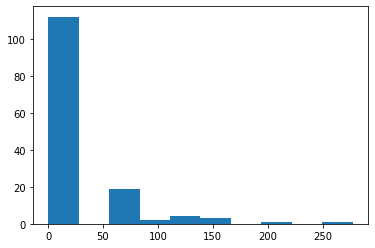

In [51]:
# Reconstruction error on fraud data points
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

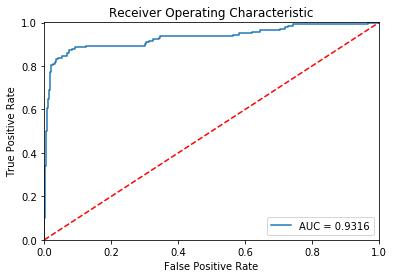

In [52]:
# Plot the AUC curve
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

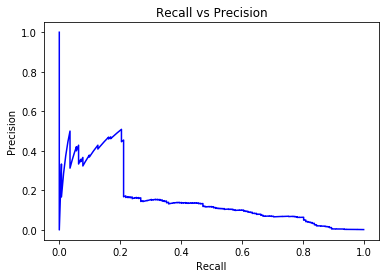

In [53]:
# PLot the Precision - recall curve
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

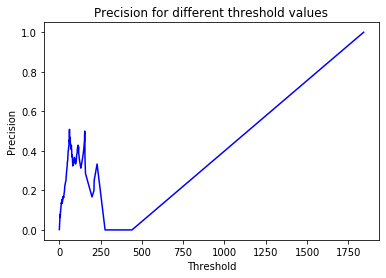

In [54]:
# PLot the precision vs reconstruction error threshold curve
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

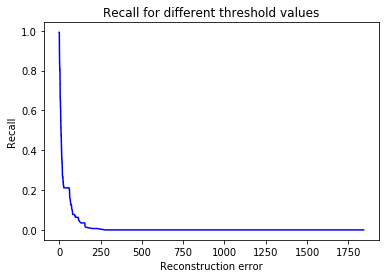

In [55]:
# PLot the recall vs reconstruction error threshold curve
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()